In [ ]:
#%matplotlib inline
## Packages
'''Import all the necessary packages and modules'''


%matplotlib qt4 
#uses matplotlib qt4 interface

import hyperspy.api as hs #call hyperspy by hs
hs.preferences.gui(toolkit='traitsui') #opens traitsui preference window
from scipy import signal
import scipy as sp
import numpy as np # package for playing with matrices
import matplotlib.pyplot as plt
import sys, os # python modules for interacting with computer
from tkinter import filedialog # interface for opening a file explorer
from tkinter import * # * imports all files in tkinter 
from tqdm import tqdm

In [ ]:
## Data Directory GUI
'''Getting data directory so data can easily be imported 
using this format data = hs.load('*.dm3', stack=True) to import all dm3s in folder as a stack'''


root = Tk() # Tk() is a function in tkinter that opens a window
root.directory = filedialog.askdirectory() # opens explorer window so you can find the folder of choice
root.withdraw() # closes the tkinter window since it's unnecessary
oldcwd = os.getcwd() # saves old called working directory (place where data is drawn from) as oldcwd use os.chdir(oldcwd) to go back
os.chdir(root.directory) # sets new directory
newcwd = os.getcwd() # saves new directory name as newcwd

In [ ]:
## Load Data
''' Open data and set up for analysis'''


data = hs.load('*.dm3', stack=True) # loads all dm3 in the folder directory into a stack called data
# s = data.align2D()  # Aligns data stack and removes edges. Not working well
n = np.shape(data)[2] # gives dimension of data (n x m) n = x-axis
m = np.shape(data)[1] # gives dimension of data (n x m) m = y-axis
z = np.shape(data)[0] # gives dimension of time steps = t-axis

In [ ]:
# Gets potential outliers indexes based on percentiles
# Add t-test for outliers
def outliers(value, L=5, U=95):
    """Check if value is an outlier based on percentiles
    """
    p25 = np.percentile(value, L)
    p75 = np.percentile(value, U)    
    
    lower = p25 - 1.5 * (abs(p75) - abs(p25))
    upper = p75 + 1.5 * (abs(p75) - abs(p25))
    
    return lower, upper

def get_outlier(value, L=5, U=95):
    """Check if value is an outlier based on percentiles
    """
    lower, upper = outliers(value, L, U)
    
    loutlier, uoutlier= value <= lower , value>= upper
    return loutlier, uoutlier # Give 2 output variables - e.g. lower , upper =is_outlier(data,5,95)


def diff_mat(matrix):
    
    if matrix.ndim !=2:
        raise ValueError("input not 2 dim (n x m)")
    
    nsize=matrix.shape[0]
    msize=matrix.shape[1]
    diffy=[]
    diffx=[]
    for y in range(nsize):
        row_diff = matrix[y,:]-matrix[y-1,:]
        diffy.append(row_diff)
    for x in range(msize):
        col_diff = matrix[:,x]-matrix[:,x-1]
        diffx.append(col_diff)
    diffy = np.array(diffy)
    diffx = np.transpose(np.array(diffx)) 
    
    return diffy, diffx

def diff_outliers_bool(matrix, L=5, U=95):
    
    if matrix.ndim !=2:
        raise ValueError("input not 2 dim (n x m)")
    
    diffy, diffx = diff_mat(matrix)
    
    diffy_out, diffx_out = get_outlier(diffy, L, U), get_outlier(diffx, L, U)
    diffy_bool, diffx_bool = np.logical_and(diffy_out, diffx_out)
    diff_outliers = np.logical_or(diffy_bool, diffx_bool)
    
    return diff_outliers

def diff_outliers_index(matrix, L=5, U=95):
    
    if matrix.ndim !=2:
        raise ValueError("input not 2 dim (n x m)")
    
    diff_outliers = diff_outliers_bool(matrix)
    
    diff_outliers_index = np.transpose(np.where(diff_outliers))
    
    return diff_outliers_index


# Gets the local mean around a specific index in the matrix
# with size 1=3x3 -center point = 8 points; 2=5x5 -pt = 24 folds over edge ! didn't work over 2
# Now works with any size 
def local_mean(matrix, x_axis, y_axis, size):
    local_data=[]
    numb=[]
    nsize=matrix.shape[0]-1
    msize=matrix.shape[1]-1
    for n in range(-size, size+1,1) :
        for m in range(-size, size+1,1):
            if m==0 and n==0:
                continue
                
            if  x_axis+n>=nsize and   y_axis+m>=msize:  #Cycles around far corner back to 0,0 for arbitrary size
                k = (x_axis+n) 
                k = k % nsize
                l = (y_axis+m) 
                l = l % msize
                local_data.append(matrix[k, l])
                numb.append([k, l])
                continue
            
            if x_axis+n>=nsize:
                k = x_axis+n 
                k = k% nsize
                local_data.append(matrix[k, y_axis + m])
                numb.append([k,y_axis + m])
                continue
            if   y_axis+m>=msize:
                l = (y_axis+m) 
                l = l % msize
                local_data.append(matrix[x_axis +n, l])
                numb.append([x_axis, l])
                continue
          
            local_data.append(matrix[x_axis+n,y_axis+m])
            numb.append([x_axis+n,y_axis+m])
            
        
    loc_mean=np.mean(local_data)        
        
    return loc_mean
  
    

In [ ]:
data.plot() # use h to set brightness and contrast

In [ ]:
## Analysis for data cube
'''
Replaces all data where its difference with adjacent data is outside percentiles get_outlier(data1,5,95) with a local mean.
The local mean size is set by N=number of pixels in each direction N=1 -> (3x3)-1=8 pixels; N=2 -> (5x5)-1=24 pixels 
The next part thresholds the images based on the rescaling intensity by the stack mean and then setting the thresholds
'''
slice_max=[]
slice_min=[]
for t in tqdm(range(0,z)):
    #data=np.random.rand(3,4) used for testing purposes
    data1 = data.data[t,:,:]
    a = diff_outliers_index(data1)
    N=3
    
    for [i,j] in a: # looks at positions where true only - faster than looking at all values      
        loc_mean=local_mean(data1, i, j, N)
        data1[i,j] = loc_mean # replaces all values where true with the local mean
    
    slice_max.append(np.max(data1))
    slice_min.append(np.min(data1))
    
    data.data[t,:,:]=data1

high_thresh = min(slice_max)
low_thresh = max(slice_min)
data = np.array(data)
stack_mean=np.mean(data)
data=hs.signals.Signal2D(data)

for t in tqdm(range(0,z)):
    data1=data.data[t,:,:]
    
    data1_mean=np.mean(data1)
    data1=data1*(stack_mean/data1_mean) #normalize image intensity after getting rid of outliers

    thresh_max_bool=data1>=min(slice_max)
    thresh_min_bool=data1<=max(slice_min)
    
    thresh_max = np.where(thresh_max_bool)
    thresh_min = np.where(thresh_min_bool)
    
    data1[thresh_max]=min(slice_max)
    data1[thresh_min]=max(slice_min)
    

    
    
    data.data[t,:,:]=data1

data=hs.signals.Signal2D(data)  #Converts data back to a Signal2D so hyperspy will work for it



In [ ]:
data.plot()

In [ ]:
np.mean(data.data[1,:,:])

In [ ]:
a=np.random.rand(5,5)
x=np.mean(a)
x
c=a>np.mean(a)
b=np.where(c)
a

In [ ]:
min(slice_max)

In [ ]:
a[b]=1

In [ ]:
rec = hs.roi.Line2DROI?
rectangle_ROI = rec.interactive(data,color='blue')

In [ ]:
line = hs.roi.Line2DROI(100,200,300,400,500)
line_ROI = line.interactive(data, color='green')

In [ ]:
    line.x1

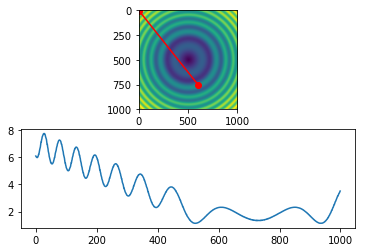

In [4]:
## Use this to determine arbitrary rectangular data selection. 
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt

#-- Generate some data...
x, y = np.mgrid[-5:5:0.01, -5:5:0.01]
z = np.sqrt(x**2 + y**2) + np.sin(x**2 + y**2)

#-- Extract the line...
# Make a line with "num" points...
x0, y0 = 5, 4.5 # These are in _pixel_ coordinates!!
x1, y1 = 600, 750
num = 1000
x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)

# Extract the values along the line, using cubic interpolation
zi = z[x.astype(np.int), y.astype(np.int)]

#-- Plot...
fig, axes = plt.subplots(nrows=2)
axes[0].imshow(z)
axes[0].plot([x0, x1], [y0, y1], 'ro-')
axes[0].axis('image')

axes[1].plot(zi)

plt.show()

In [ ]:
from __future__ import print_function
from matplotlib.widgets import RectangleSelector
import numpy as np
import matplotlib.pyplot as plt


def line_select_callback(eclick, erelease):
    'eclick and erelease are the press and release events'
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    print("(%3.2f, %3.2f) --> (%3.2f, %3.2f)" % (x1, y1, x2, y2))
    #print(" The button you used were: %s %s" % (eclick.button, erelease.button))


def toggle_selector(event):
    print(' Key pressed.')
    if event.key in ['Q', 'q'] and toggle_selector.RS.active:
        print(' RectangleSelector deactivated.')
        toggle_selector.RS.set_active(False)
    if event.key in ['A', 'a'] and not toggle_selector.RS.active:
        print(' RectangleSelector activated.')
        toggle_selector.RS.set_active(True)


fig, current_ax = plt.subplots()                 # make a new plotting range
N = 100000                                       # If N is large one can see
x = np.linspace(0.0, 10.0, N)                    # improvement by use blitting!

plt.plot(x, +np.sin(.2*np.pi*x), lw=3.5, c='b', alpha=.7)  # plot something
plt.plot(x, +np.cos(.2*np.pi*x), lw=3.5, c='r', alpha=.5)
plt.plot(x, -np.sin(.2*np.pi*x), lw=3.5, c='g', alpha=.3)

print("\n      click  -->  release")

# drawtype is 'box' or 'line' or 'none'
toggle_selector.RS = RectangleSelector(current_ax, line_select_callback,
                                       drawtype='none', useblit=True,
                                       button=[1, 3],  # don't use middle button
                                       minspanx=5, minspany=5,
                                       spancoords='pixels',
                                       interactive=True)
plt.connect('key_press_event', toggle_selector)
plt.show()

In [ ]:
from __future__ import print_function
from matplotlib.widgets import RectangleSelector
import numpy as np
import matplotlib.pyplot as plt


def line_select_callback(eclick, erelease):
    'eclick and erelease are the press and release events'
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    print("(%3.2f, %3.2f) --> (%3.2f, %3.2f)" % (x1, y1, x2, y2))
    #print(" The button you used were: %s %s" % (eclick.button, erelease.button))

fig, current_ax = plt.subplots()                 # make a new plotting range
N = 100000                                       # If N is large one can see
x = np.linspace(0.0, 10.0, N)                    # improvement by use blitting!

plt.plot(x, +np.sin(.2*np.pi*x), lw=3.5, c='b', alpha=.7)  # plot something
plt.plot(x, +np.cos(.2*np.pi*x), lw=3.5, c='r', alpha=.5)
plt.plot(x, -np.sin(.2*np.pi*x), lw=3.5, c='g', alpha=.3)

print("\n      click  -->  release")

# drawtype is 'box' or 'line' or 'none'
a = VertexSelector(current_ax, line_select_callback,
                                       drawtype='none', useblit=True,
                                       button=[1, 3],  # don't use middle button
                                       minspanx=5, minspany=5,
                                       spancoords='pixels',
                                       interactive=True)
plt.connect('key_press_event', line_select_callback)
plt.show()

In [ ]:
line_select_callback()

In [ ]:
from __future__ import print_function
import sys
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(0.0, 1.0, 0.01)
s = np.sin(2 * np.pi * t)
fig, ax = plt.subplots()
ax.plot(t, s)


def on_click(event):
    # get the x and y coords, flip y from top to bottom
    x, y = event.x, event.y
    if event.button == 1:
        if event.inaxes is not None:
            print('data coords %f %f' % (event.xdata, event.ydata))
def line_select_callback(eclick, erelease):
    'eclick and erelease are the press and release events'
    x0, y0 = eclick.xdata, eclick.ydata
    x1, y1 = erelease.xdata, erelease.ydata
    print("(%3.2f, %3.2f) --> (%3.2f, %3.2f)" % (x1, y1, x2, y2))            
    num = 1000
    x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)



plt.connect('button_press_event', on_click)

if "test_disconnect" in sys.argv:
    print("disconnecting console coordinate printout...")
    plt.disconnect(binding_id)

plt.show()